<a href="https://colab.research.google.com/github/Gourdji19/Infogan_Mnist_pytorch/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22P100_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!nvidia-smi

Mon Jun  7 19:39:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    57W / 149W |    902MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [103]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [104]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [105]:
import numpy as np
import datetime
import os, sys

In [106]:
import sys
!{sys.executable} -m pip install tensorboardX

In [107]:
from tensorboardX import SummaryWriter

In [108]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [109]:
MODEL_NAME = 'infoGAN'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [111]:
def sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=None, supervised=False):
    z = torch.randn(batch_size, n_noise).to(DEVICE)
    if supervised:
        c_discrete = to_onehot(label).to(DEVICE) # (B,10)
    else:
        c_discrete = to_onehot(torch.LongTensor(batch_size, 1).random_(0, n_c_discrete)).to(DEVICE) # (B,10)
    c_continuous = torch.zeros(batch_size, n_c_continuous).uniform_(-1, 1).to(DEVICE) # (B,2)
    c = torch.cat((c_discrete.float(), c_continuous), 1)
    return z, c

In [112]:
def get_sample_image():
    """
        save sample 100 images
    """
    images = []
    # continuous code
    for cc_type in range(2):
        for num in range(10):
            fix_z = torch.randn(1, n_noise)
            z = fix_z.to(DEVICE)
            cc = -1
            for i in range(10):
                cc += 0.2
                c_discrete = to_onehot(num).to(DEVICE) # (B,10)
                c_continuous = torch.zeros(1, n_c_continuous).to(DEVICE)
                c_continuous.data[:,cc_type].add_(cc)
                c = torch.cat((c_discrete.float(), c_continuous), 1)
                y_hat = G(z, c)
                line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
            all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
        img = all_img.cpu().data.numpy()
        images.append(img)
    # discrete code
    for num in range(10):
        c_discrete = to_onehot(num).to(DEVICE) # (B,10)
        for i in range(10):
            z = torch.randn(1, n_noise).to(DEVICE)
            c_continuous = torch.zeros(1, n_c_continuous).to(DEVICE)
            c = torch.cat((c_discrete.float(), c_continuous), 1)
            y_hat = G(z, c)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    images.append(img)
    return images[0], images[1], images[2]

In [113]:
def log_gaussian(c, mu, var):
    """
        criterion for Q(condition classifier)
    """
    return -((c - mu)**2)/(2*var+1e-8) - 0.5*torch.log(2*np.pi*var+1e-8)

In [114]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(# 28 -> 14
            nn.Conv2d(in_channel, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        self.layer2 = nn.Sequential(# 14 -> 7
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.layer3 = nn.Sequential(#
            nn.Linear(128*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = self.layer1(x)
        y_ = self.layer2(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.layer3(y_)
        d = self.fc(y_) # Real / Fake        
        return d, y_ # return with top layer features for Q

In [115]:
class Qrator(nn.Module):
    """
        Regularization Network for increasing Mutual Information
    """
    def __init__(self):
        super(Qrator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 14),
        )
        
    def forward(self, x):
        # Seperate code
        c = self.fc(x)
        c_discrete = torch.softmax(c[:, :10], dim=-1) # Digit Label {0~9}
        c_mu = c[:, 10:12] # mu & var of Rotation & Thickness
        c_var = c[:, 12:14].exp() # mu & var of Rotation & Thickness
        return c_discrete, c_mu, c_var

In [116]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=62, code_size=12, num_classes=784):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size+code_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(# input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(# input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, z, c):
        z = z.view(z.size(0), -1)
        c = c.view(c.size(0), -1)
        noise = torch.cat((z, c), 1)
#         print(noise.size())
        x_ = self.layer1(noise)
        x_ = self.layer2(x_)
        x_ = x_.view(x_.size(0), 128, 7, 7)
        x_ = self.layer3(x_)
        x_ = self.layer4(x_)
        return x_

In [117]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
Q = Qrator().to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [118]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [119]:
def get_mnist_subset(*, labels_to_be_selected=range(10), count_images_to_select=60000):
  """
  returns: MNIST dataset subset filtered by labels or
   just random selected subset
  usage:
    if filter by labels selection:
      mnist = get_mnist_subset(labels_to_be_selected=[0, 1, 2, 3])
    if by random image selection:
      mnist = get_mnist_subset(count_images_to_select=3200)
  """
  ################################
  #### SELECT IMAGES ####
  ################################

  mnist = datasets.MNIST(root='../data/',
                         train=True,
                         transform=transform,
                         download=True)

  by_labels = True
  if count_images_to_select != 60000:
    by_labels = False

  selected_images_idx = torch.zeros_like(mnist.targets).bool()
  if by_labels:
    for l_ in labels_to_be_selected:
      selected_images_idx = torch.logical_or(selected_images_idx,
                                             mnist.targets == l_)
  else:
    indices = torch.randperm(len(mnist.targets))[:count_images_to_select]
    selected_images_idx[indices] = True
  print(f"Total images count: {selected_images_idx.sum()}")

  ### select from mnist by indexes
  mnist.targets = mnist.targets[selected_images_idx]
  mnist.data = mnist.data[selected_images_idx]
  return mnist

In [120]:
mnist = get_mnist_subset(count_images_to_select=10000)

Total images count: 10000


In [121]:
batch_size = 64

In [122]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

In [123]:
bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()

D_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.99))
G_opt = torch.optim.Adam([{'params':G.parameters()}, {'params':Q.parameters()}], lr=1e-3, betas=(0.5, 0.99))

In [124]:
max_epoch = 200 # need more than 200 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 62
n_c_discrete, n_c_continuous = 10, 2

D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [125]:
writer = SummaryWriter()

In [126]:
loss_d_arr, loss_g_arr = [], []

for epoch in range(max_epoch+1):
    for idx, (images, labels) in enumerate(data_loader):
        step += 1
        labels = labels.view(batch_size, 1)
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs, _, = D(x)
        D_x_loss = bce_loss(x_outputs, D_labels)

        z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
        z_outputs, _, = D(G(z, c))
        D_z_loss = bce_loss(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D_opt.zero_grad()


        loss_d_arr.append(D_loss.cpu().detach().numpy())


        D_loss.backward()
        D_opt.step()

        # Training Generator
        z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
        c_discrete_label = torch.max(c[:, :-2], 1)[1].view(-1, 1)

        z_outputs, features = D(G(z, c)) # (B,1), (B,10), (B,4)
        c_discrete_out, cc_mu, cc_var = Q(features)

        G_loss = bce_loss(z_outputs, D_labels)
        Q_loss_discrete = ce_loss(c_discrete_out, c_discrete_label.view(-1))
        Q_loss_continuous = -torch.mean(torch.sum(log_gaussian(c[:, -2:], cc_mu, cc_var), 1)) # N(x | mu,var) -> (B, 2) -> (,1)
        mutual_info_loss = Q_loss_discrete + Q_loss_continuous*0.1

        GnQ_loss = G_loss + mutual_info_loss
        G_opt.zero_grad()
        loss_g_arr.append(GnQ_loss.cpu().detach().numpy())

        GnQ_loss.backward()
        G_opt.step()

        if step > 500 and step % 100 == 0:
            writer.add_scalar('loss/total', GnQ_loss, step)
            writer.add_scalar('loss/Q_discrete', Q_loss_discrete, step)
            writer.add_scalar('loss/Q_continuous', Q_loss_continuous, step)
            writer.add_scalar('loss/Q', mutual_info_loss, step)
            writer.add_histogram('output/mu', cc_mu)
            writer.add_histogram('output/var', cc_var)
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}, GnQ Loss: {}, Time: {}'\
                  .format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), GnQ_loss.item(), str(datetime.datetime.today())[:-7]))
            
        if step % 1000 == 0:
            G.eval()
            G.train()
writer.export_scalars_to_json("./all_summary.json")
writer.close()

Epoch: 3/200, Step: 500, D Loss: 1.0698353052139282, G Loss: 1.0194722414016724, GnQ Loss: 2.543480157852173, Time: 2021-06-07 19:39:59
Epoch: 6/200, Step: 1000, D Loss: 1.085753083229065, G Loss: 1.0104293823242188, GnQ Loss: 2.5252604484558105, Time: 2021-06-07 19:40:21
Epoch: 9/200, Step: 1500, D Loss: 1.161332607269287, G Loss: 1.0758318901062012, GnQ Loss: 2.537632942199707, Time: 2021-06-07 19:40:44
Epoch: 12/200, Step: 2000, D Loss: 1.0548406839370728, G Loss: 1.0691293478012085, GnQ Loss: 2.495953321456909, Time: 2021-06-07 19:41:06
Epoch: 16/200, Step: 2500, D Loss: 0.8788594603538513, G Loss: 1.3044378757476807, GnQ Loss: 2.768538475036621, Time: 2021-06-07 19:41:29
Epoch: 19/200, Step: 3000, D Loss: 0.9510204195976257, G Loss: 1.2968380451202393, GnQ Loss: 2.734203815460205, Time: 2021-06-07 19:41:52
Epoch: 22/200, Step: 3500, D Loss: 0.9379628300666809, G Loss: 1.3292863368988037, GnQ Loss: 2.769083261489868, Time: 2021-06-07 19:42:14
Epoch: 25/200, Step: 4000, D Loss: 0.75

In [127]:
import sys
!{sys.executable} -m pip install matplotlib

In [128]:
import matplotlib.pyplot as plt

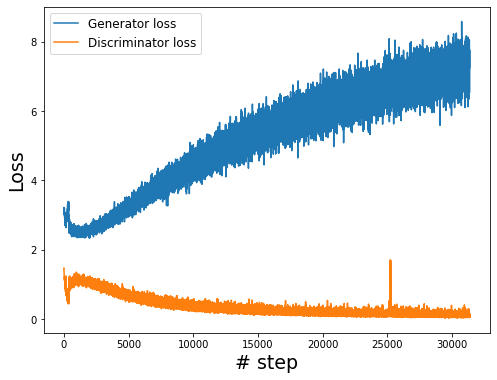

In [129]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(loss_g_arr)), loss_g_arr, label="Generator loss")
ax.plot(range(len(loss_d_arr)), loss_d_arr, label="Discriminator loss")
ax.set_xlabel('# step', fontsize=19)
ax.set_ylabel('Loss', fontsize=19)
plt.legend(fontsize=12)

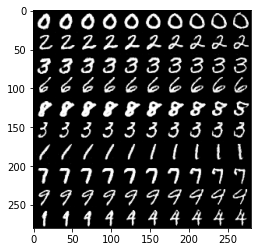

In [130]:
# generation to image
G.eval()
imshow(get_sample_image()[0], cmap='gray')

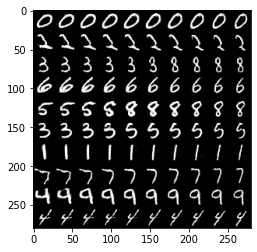

In [131]:
imshow(get_sample_image()[1], cmap='gray')

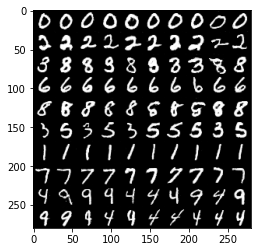

In [132]:
imshow(get_sample_image()[2], cmap='gray')